## Yelp Review Sentiment Classification

The task: perform Yelp Review Sentiment Classification by comparing three types of embeddings:

- Bag of Words
- TF-IDF
- Word2Vec

Which model performs better?

You find below some help that can guide you. You're not forced to follow those steps.

In [1]:
# !pip install scikit-learn

In [2]:
# !pip install -U spacy

In [3]:
# !python -m spacy download en

In [4]:
#!python -m spacy download en_core_web_sm

### Data Cleaning Options
- Case Normalization
- Removing Stop Words
- Removing Punctuations or Special Symbols
- Lemmatization or Stemming
- Parts of Speech Tagging
- Entity Detection


### Bag of Words - The Simplest Word Embedding Technique

This is one of the simplest methods of embedding words into numerical vectors. It is not often used in practice due to its oversimplification of language, but often the first embedding technique to be taught in the classroom setting.

```
doc1 = "I am high"
doc2 = "Yes I am high"
doc3 = "I am kidding" 

```

### Bag of Words and Tf-idf 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

tf–idf for “Term Frequency times Inverse Document Frequency

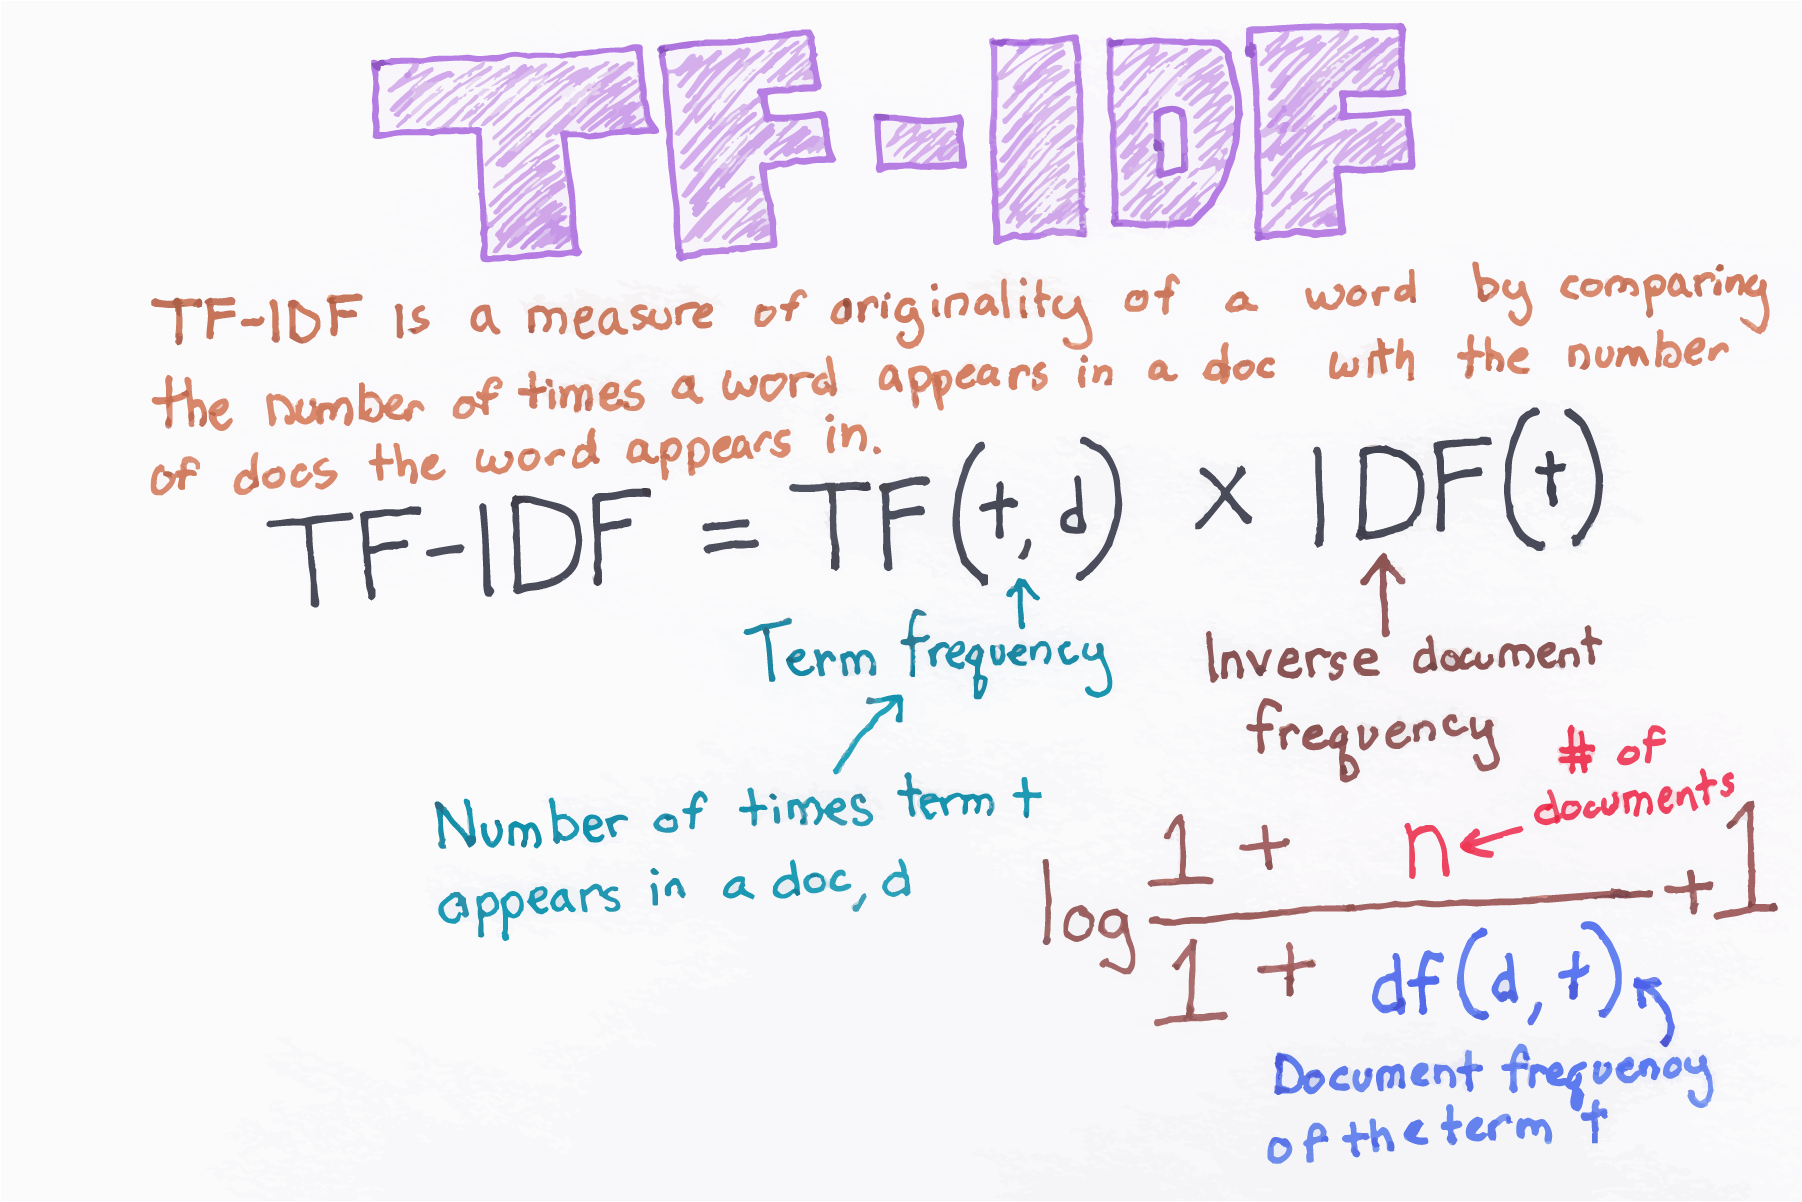

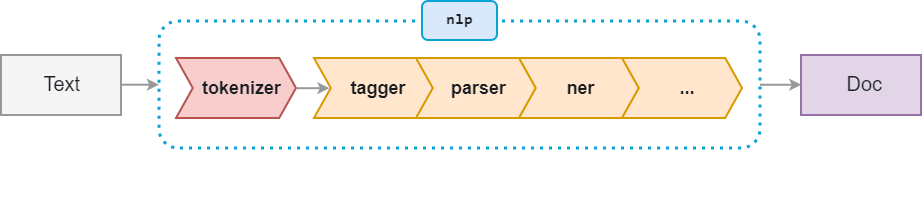

## Prepare the data

In [2]:
import pandas as pd
train_data = pd.read_csv("data/train_data.csv", index_col="Unnamed: 0")
test_data = pd.read_csv("data/test_data.csv", index_col="Unnamed: 0")

In [3]:
from sklearn.model_selection import train_test_split

X = train_data['Review']
y = train_data['Sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_test = test_data['Review']
y_test = test_data['Sentiment']

In [4]:
train_data.head()

Review  Sentiment
1000  So there is no way for me to plug it in here i...          0
1001                        Good case, Excellent value.          1
1002                             Great for the jawbone.          1
1003  Tied to charger for conversations lasting more...          0
1004                                  The mic is great.          1

In [5]:
test_data.head()

Review  Sentiment
0                           Wow... Loved this place.          1
1                                 Crust is not good.          0
2          Not tasty and the texture was just nasty.          0
3  Stopped by during the late May bank holiday of...          1
4  The selection on the menu was great and so wer...          1

# Let's Get Started

In [6]:
import spacy
from spacy import displacy

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
nlp("Hello")[0].lemma_

'hello'

In [9]:
nlp("Hello")[0]

Hello

## Preprocessing

We need to create a function that given the text of a sentence preprocess it.

Some of the operations we can do:
- Case Normalization (automatic with lemmatization)
- Removing Stop Words
- Removing Punctuations or Special Symbols
- Lemmatization or Stemming

To insert it in a pipeline, you have to be sure that you start from a sentence and you get text tokens as output:

In [10]:
def preprocessing(sentence):
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return tokens

In [15]:
preprocessing('Antonio has a fake beard ...')

['antonio', 'fake', 'beard']

### Text Classification 

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [19]:
# Define an instance of the TfidfVectorizer which receive your 
# preprocessing function
apple = preprocessing('Antonio has a fake beard ...')
# tfidf = TfidfVectorizer(apple) # giving warning
tfidf = TfidfVectorizer(tokenizer = preprocessing)
tfidf

TfidfVectorizer(tokenizer=<function preprocessing at 0x00000196A4D5FB80>)

In [20]:
# Define an instance of the TfidfVectorizer which receive your 
# preprocessing function and it has as n-grams range (1,5)

tfidf1_5 = TfidfVectorizer(tokenizer = preprocessing, ngram_range=(1, 5))
tfidf1_5

TfidfVectorizer(ngram_range=(1, 5),
                tokenizer=<function preprocessing at 0x00000196A4D5FB80>)

In [ ]:
# Define an instance of the Countvectorizer which receive your 
# preprocessing function and it has as n-grams range (1,3)

bow = CountVectorizer(tokenizer = preprocessing,ngram_range=(1, 5))

In [22]:
# define a word vectorizer that use the spacy's word vectors. Replace the
# two comments with your code. If you don't remember how to access
# the embeddings of a doc use dir(doc) and see if there is anything
# that makes sense

import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model='en_core_web_lg'):
        self.model = model

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

☝️In this case, however, we are not using our preprocessing pipeline and we are consider only sentence embeddings and not single token embeddings. In this way, it is more convenient because we have a single vector for each sentence and we can handle different length sentences. The vector representation for the entire Doc is calculated by averaging the vectors for each Token in the Doc.

This may result in a less meaningful features than the one by using Tf-Idf for example. We will see how to handle this next week!

In [24]:
# import and load a classifier from sklearn. In class, I used 
# from sklearn.svm import LinearSVC
# but feel free to experiment with other models

from sklearn.svm import LinearSVC

classifier = LinearSVC()

In [57]:
# Build a pipeline that contains only your tfidf and fit_transform it
# on your corpus train_data["Review"]

pipe = Pipeline([('tfidf', tfidf)]).fit_transform(X)
pipe

<1748x3364 sparse matrix of type '<class 'numpy.float64'>'
	with 11310 stored elements in Compressed Sparse Row format>

In [58]:
# Build a pipeline that contains your tfidf and the classifier

pipeline = Pipeline([ ('tfidf', tfidf), ('clf',classifier) ]) 
pipeline_1_5 = Pipeline([ ('tfidf', tfidf), ('clf',classifier) ]) 

In [59]:
# fit on your data (X_train, y_train)

pipeline.fit(X_train, y_train)
pipeline_1_5.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function preprocessing at 0x00000196A4D5FB80>)),
                ('clf', LinearSVC())])

In [62]:
# test on your validation data with the predict method

y_pred = pipeline.predict(X_val)
y_pred_1_5 = pipeline_1_5.predict(X_val)

In [63]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       269
           1       0.78      0.87      0.82       256

    accuracy                           0.82       525
   macro avg       0.82      0.82      0.82       525
weighted avg       0.82      0.82      0.81       525



In [64]:
print(classification_report(y_val, y_pred_1_5)) # no point in using n-grams ??

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       269
           1       0.78      0.87      0.82       256

    accuracy                           0.82       525
   macro avg       0.82      0.82      0.82       525
weighted avg       0.82      0.82      0.81       525



In [65]:
# test on your test data

y_pred_test = pipeline.predict(X_test)

In [47]:
# y_pred_test

In [66]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       500
           1       0.70      0.74      0.72       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



In [67]:
confusion_matrix(y_val, y_pred)


array([[206,  63],
       [ 34, 222]], dtype=int64)

In [68]:
confusion_matrix(y_test, y_pred_test)

array([[344, 156],
       [128, 372]], dtype=int64)

In [75]:
# Test it with your examples
pipeline.predict(['Wow, this is amazing lesson'])

array([1], dtype=int64)

In [74]:
pipeline.predict(['Wow, this sucks'])

array([0], dtype=int64)

In [77]:
pipeline.predict(['Worth of watching it. Please like it'])

array([1], dtype=int64)

In [78]:
pipeline.predict(['Loved it. amazing'])

array([1], dtype=int64)

In [80]:
pipeline.predict(['Antonio hates me'])

array([0], dtype=int64)

In [81]:
pipeline.predict(['Antonio loves me']) 

array([1], dtype=int64)